**1. Importing Libraries**

**2. Loading the Dataset**

**3. Data Visualization**
*   Distribution of Target Values
*   Length of tweets v/s Number of tweets
*   Number of Words v/s Number of Tweets

**4. Missing Values Analysis**

**5. Data Prepocessing**
*   Removing URL & Special Characters
*   Tokenization
*   Glove Vector Embeddings

------------------------

**6. LSTM Model**
*   Model Creation
*   Model Training
*   Prediction & Evaluation


**7. Bert Model**
*   Text Preprocessing for Bert
*   Model Creation
*   Model Training
*   Prediction & Evaluation

**8. BERT embeddings and LSTM**


In [29]:
#Run this cell to mount to google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Importing Libraries

In [1]:
pip install ktrain

In [2]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import spacy                                              # For tokenization, lemmatization, removing stop words & punctuations.
from keras.layers import LSTM, Dense, Dropout, Activation # Layers of keras used in LSTM Model.
from keras.models import Sequential                       # Sequential Neural Network
from keras.callbacks import EarlyStopping                 # Early Stopping Callback in the NN
import tensorflow as tf
import ktrain                                             # For Bert Model Implementation.
from ktrain import text                                   # Preprocessing text for the Bert Model.
sns.set()
nlp = spacy.load("en_core_web_sm",disable=["tagger", "parser", "ner"])

#2. Loading the Dataset

In [3]:
#Include the dataset inside here 
data = pd.read_csv('/content/combined_dataset.csv', encoding='latin1')

#Eliminating the varibles that is not useful for us 
data.drop(data.columns.difference(['id', 'Location','Tweet','Cleaned Tweet 1','target']), 1, inplace=True)

#Split the data into train and test set 
test, train = sklearn.model_selection.train_test_split(data, test_size=0.1) 


In [4]:
train_len = len(train)
test_len = len(test)
print('Training Dataset:',train_len)
print('Testing Dataset:',test_len)
train

Training Dataset: 5022
Testing Dataset: 45191


,id,Location,Tweet,Cleaned Tweet 1,target
32306,32307,"Wichita, KS","A before and after look at me, a west-sider, r...",look west sider reacting latest wichita earthq...,1
37279,37280,Los Angeles,1.5 magnitude #earthquake. 15 mi from #PineMou...,magnitude earthquake pinemountainclub ca unite...,1
40100,40101,South Africa,b'Morning Twitter \nA #Magik peek for X-Men: C...,morning twitter magik peek x men curse man thi...,1
2501,2502,ALAPPUZHA - KERALA - INDIA,James Corden when asked if He's got some Army ...,jam corden ask get army experience well confir...,0
32116,32117,"Hyderabad, India",b'#Cytel is hiring! #Client Development #Manag...,cytel hire client development manager london a...,0
...,...,...,...,...,...
30015,30016,"City of London, London","b'LADY GAGA: THE CHROMATICA BALL, 30 JUL 2021,...",lady gaga chromatica ball jul tottenham hotspu...,0
27590,27591,USA,Forecast map for this evening See Ice/Snow...,forecast map evening see ice snow radars wx we...,1
4020,4021,Naya Pakistan ðµð°,b'Earthquake in Pakistan May ALLAH protect eve...,earthquake pakistan may allah protect everyone,1
44545,44546,"Patna, India",Most people have a price and they are valued b...,people price value two emotions fear,0


#3. Data Visulization

## Distribution of target values

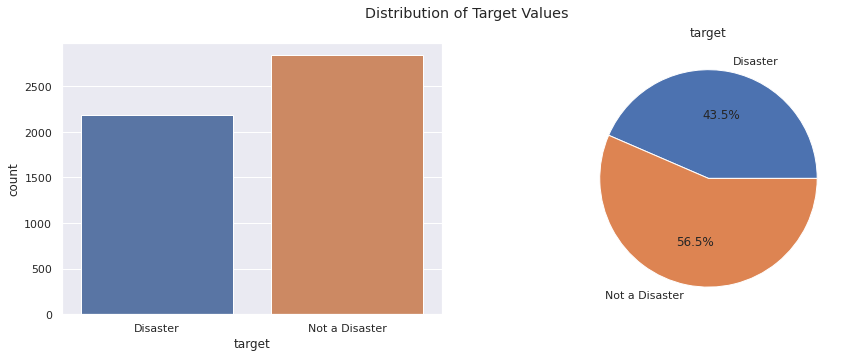

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
ax = sns.countplot(x='target',data=train,label=['Disaster', 'Not a Disaster'])
ax.set_xticklabels(['Disaster','Not a Disaster'])
plt.suptitle("Distribution of Target Values")
terms = np.array(['Disaster', 'Not a Disaster'])
weigtage = np.array([len(train[train['target'] == 0]),len(train[train['target'] == 1])])
plt.subplot(1, 2, 2)
plt.pie(weigtage,labels=terms, autopct="%1.1f%%")
plt.title('target')
plt.show()

## Length of tweets v/s Number of tweets

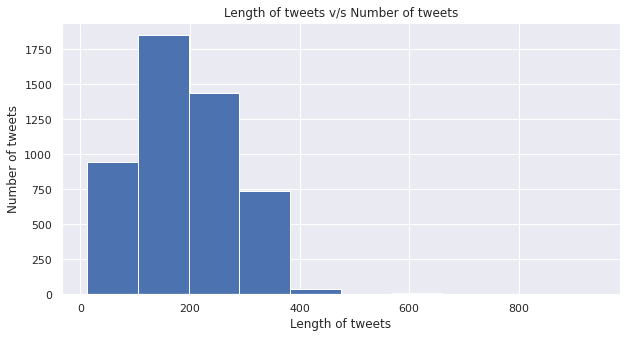

In [6]:
plt.figure(figsize=(10,5))
word_len = train['Tweet'].map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Length of tweets')
plt.ylabel('Number of tweets')
plt.title('Length of tweets v/s Number of tweets')
plt.show()

## Number of Words v/s Number of Tweets

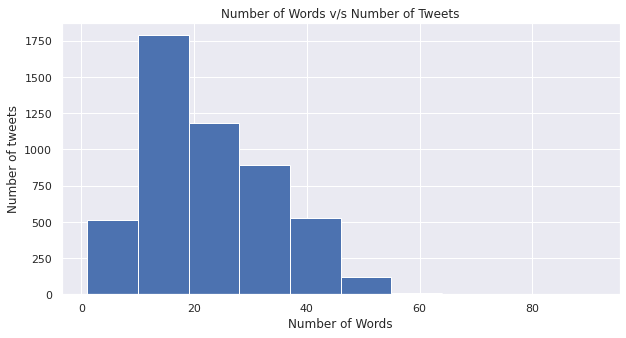

In [7]:
plt.figure(figsize=(10,5))
word_len = train['Tweet'].str.split().map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Number of Words')
plt.ylabel('Number of tweets')
plt.title('Number of Words v/s Number of Tweets')
plt.show()

#4. Missing Values Analysis

In [8]:
#Create a function to analyze the missing data
def missing_val_analysis(data):
    missing_values = data.isnull().sum()
    missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
    missing_values_data = pd.DataFrame(missing_values)
    missing_values_data.reset_index(level=0, inplace=True)
    missing_values_data.columns = ['Feature','Number of Missing Values']
    missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(data)
    return missing_values_data

In [9]:
missing_val_analysis(train) # Missing value analysis in the training data.

,Feature,Number of Missing Values,Percentage of Missing Values
0,Location,1273,25.348467
1,Cleaned Tweet 1,3,0.059737


Since the number of rows having missing keywords is very less, so we should just drop the rows that have the missing value in "Cleaned Tweet 1", and add the values of "Clean Tweets 1" to the "Tweets" so that we can treat them as "keywords". We drop the "Cleaned Tweets 1" entirely.

Since location is not likely to help the model with its prediction, therefore we would drop this column for now.¶

Sort the value in train set as well based on the "id"

In [10]:
train = train[train['Cleaned Tweet 1'].notna()]
train['Tweet'] = train['Tweet'] + ' ' + train['Cleaned Tweet 1']
train['Tweet'] = train['Tweet'].apply(lambda x: x.strip())
train.drop(['Cleaned Tweet 1'],axis=1,inplace=True)
train.drop(['Location'],axis=1,inplace=True)
train = train.sort_values(by = 'id')

train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,id,Tweet,target
7,8,b'Sherlock Holmes Museum \xe2\x80\x94 221B Bak...,0
13,14,"b'Sending some Goodnight Relaxation Vibes, to ...",0
14,15,b'Storm by Antonis Skempes - https://t.co/ELYQ...,1
23,24,"b'Even the during the darkest of times, she st...",0
24,25,b'Getting better everyday \xf0\x9f\xa4\x8d #ha...,0


In [11]:
missing_val_analysis(test)

,Feature,Number of Missing Values,Percentage of Missing Values
0,Location,10675,23.621960
1,Cleaned Tweet 1,9,0.019915


We would take the same action here as we took for the training dataset.

In [12]:
test = test[test['Cleaned Tweet 1'].notna()]
test['Tweet'] = test['Tweet'] + ' ' + test['Cleaned Tweet 1']
test['Tweet'] = test['Tweet'].apply(lambda x: x.strip())
test.drop(['Cleaned Tweet 1'],axis=1,inplace=True)
test.drop(['Location'],axis=1,inplace=True)
test = test.sort_values(by = 'id')

test.head()

,id,Tweet,target
0,1,b'there is only one way to stop #earthquake in...,1
1,2,Breaking news. #Ambulance delays led to 'secon...,1
2,3,b'#Sunday #Fun #Day\n#PS4\n#Fortnite\n#Spotify...,0
3,4,b'#Florida #AlwaysAndForever #earthquake #B117...,1
4,5,#aa4pv like I said bitches \nFUCK YOU ALL #NAS...,0


# 5. Data Prepocessing

## Removing URL & Special Characters



In [13]:
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+','',text)
def remove_char(text):
    return re.sub(r'[^A-Za-z0-9 ]+', '', text)

def remove_preprocess(text):
    return remove_char(remove_url(text))

In [14]:
train['Tweet'] = train['Tweet'].apply(lambda x: remove_preprocess(x))
test['Tweet'] = test['Tweet'].apply(lambda x: remove_preprocess(x))
train.head()

,id,Tweet,target
7,8,bSherlock Holmes Museum xe2x80x94 221B Baker L...,0
13,14,bSending some Goodnight Relaxation Vibes to al...,0
14,15,bStorm by Antonis Skempes YouPic photography...,1
23,24,bEven the during the darkest of times she stil...,0
24,25,bGetting better everyday xf0x9fxa4x8d happy bl...,0


## Tokenization

Here we would combine the training and testing data since tokenization needs to be performed on both the dataset.Also we would further analyze the combined data to draw out more visualizations.

In [15]:
data = pd.concat([train,test],axis=0,sort=False)
data.drop(['target'],axis=1,inplace=True)
data.head()

,id,Tweet
7,8,bSherlock Holmes Museum xe2x80x94 221B Baker L...
13,14,bSending some Goodnight Relaxation Vibes to al...
14,15,bStorm by Antonis Skempes YouPic photography...
23,24,bEven the during the darkest of times she stil...
24,25,bGetting better everyday xf0x9fxa4x8d happy bl...


In [16]:
def filtered_token(token):
    if token.is_stop or token.is_space or token.like_num or token.like_url or token.like_email or token.is_digit or token.is_punct or len(token.lemma_) <= 2:
        return False
    return True
        

def tokenize(text):
    tokens = []
    doc = nlp(text)
    for token in doc:
        if filtered_token(token):
            tokens.append(token.lemma_.lower())
    return tokens

In [17]:
data['tokens'] = data['Tweet'].apply(lambda x: tokenize(x))
data.head()

,id,Tweet,tokens
7,8,bSherlock Holmes Museum xe2x80x94 221B Baker L...,"[bsherlock, holmes, museum, xe2x80x94, 221b, b..."
13,14,bSending some Goodnight Relaxation Vibes to al...,"[bsending, goodnight, relaxation, vibes, fan, ..."
14,15,bStorm by Antonis Skempes YouPic photography...,"[bstorm, antonis, skempes, youpic, photography..."
23,24,bEven the during the darkest of times she stil...,"[beven, dark, time, smile, xf0x9fx92x95xf0x9fx..."
24,25,bGetting better everyday xf0x9fxa4x8d happy bl...,"[bgetting, well, everyday, xf0x9fxa4x8d, happy..."


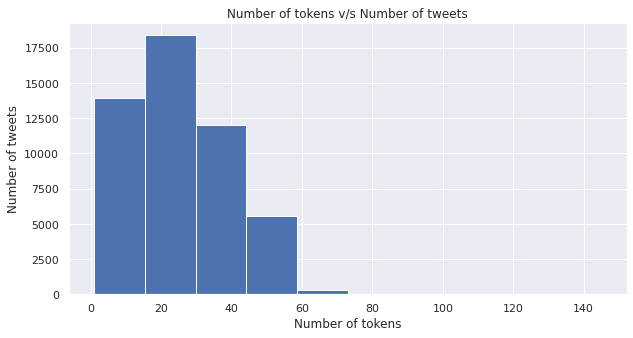

In [18]:
plt.figure(figsize=(10,5))
word_len = data['tokens'].map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Number of tokens')
plt.ylabel('Number of tweets')
plt.title('Number of tokens v/s Number of tweets')
plt.show()

## Glove Vector Embeddings

Here would be using the glove vectors 300 dimensions file.

In [19]:
glove_vec_file = open('/content/glove.6B.300d.txt')
embeddings = {}
for line in glove_vec_file:
    values = line.split()
    word = values[0]
    embedding = np.array(values[1:])
    embeddings[word] = embedding
glove_vec_file.close()

In [20]:
def embeddings_out(data,maxlen=20):
    output = np.zeros((data.shape[0],20,300))
    for ix in range(len(data)):
        curr_len = min(maxlen,len(data.iloc[ix]['tokens']))
        for jx in range(curr_len):
            word = str(data.iloc[ix]['tokens'][jx])
            if word in embeddings:
                output[ix][jx] = embeddings[data.iloc[ix]['tokens'][jx]]
    return output

In [21]:
X = embeddings_out(data) # Final training dataset to feed into LSTM model.
X.shape

(50201, 20, 300)

Splitting the dataset into training and testing parts.

In [22]:
X_train = X[:len(train)]
X_test = X[len(train):]
y_train = train['target'].values
len(X_train),len(X_test),len(y_train)

(5019, 45182, 5019)

===================================================================================================================

#7. LSTM Model



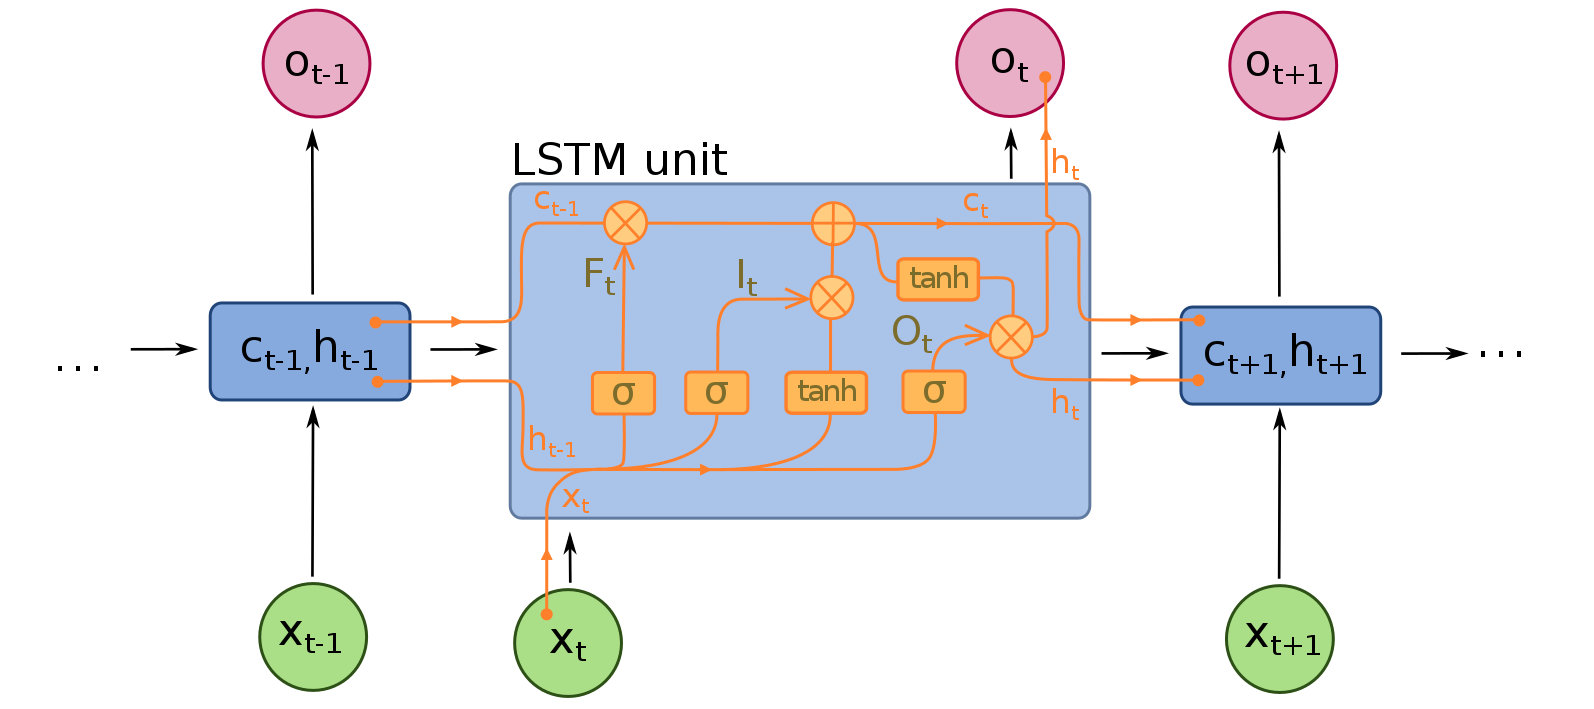

##Model Creation

Here we have used the Stacked LSTMs to get better accuracy as compared to a single LSTM model.

In [23]:
def create_model():
    model = Sequential()
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2])))
    model.add(Dropout(0.1))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Activation('softmax'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [24]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 64)            93440     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

##Model Training



We would be using early stopping callback and would use 1/10th of the training data as validation to estimate the optimum number of epochs that would prevent overfitting

In [25]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

hist = model.fit(X_train,y_train,epochs=50,batch_size=64,shuffle=True,validation_split=0.1,callbacks=[early_stop])

Epoch 1/50
71/71 [==============================] - 38s 33ms/step - loss: 0.6542 - accuracy: 0.7898 - val_loss: 0.5601 - val_accuracy: 0.9243
Epoch 2/50
71/71 [==============================] - 1s 10ms/step - loss: 0.5394 - accuracy: 0.9363 - val_loss: 0.5323 - val_accuracy: 0.9343
Epoch 3/50
71/71 [==============================] - 1s 9ms/step - loss: 0.4996 - accuracy: 0.9602 - val_loss: 0.5013 - val_accuracy: 0.9522
Epoch 4/50
71/71 [==============================] - 1s 13ms/step - loss: 0.4720 - accuracy: 0.9611 - val_loss: 0.4825 - val_accuracy: 0.9522
Epoch 5/50
71/71 [==============================] - 1s 10ms/step - loss: 0.4452 - accuracy: 0.9669 - val_loss: 0.4594 - val_accuracy: 0.9562
Epoch 6/50
71/71 [==============================] - 1s 9ms/step - loss: 0.4190 - accuracy: 0.9699 - val_loss: 0.4376 - val_accuracy: 0.9602
Epoch 7/50
71/71 [==============================] - 1s 9ms/step - loss: 0.3971 - accuracy: 0.9734 - val_loss: 0.4195 - val_accuracy: 0.9602
Epoch 8/50
71/7

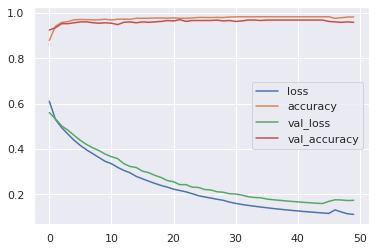

In [26]:
losses = pd.DataFrame(model.history.history)
losses.plot()

Training the model with full training data and optimum number of epochs!!¶


In [27]:
model = create_model()

In [28]:
history = model.fit(x=X_train,y=y_train,
          batch_size=64,epochs=20,shuffle=True)

Epoch 1/20
79/79 [==============================] - 5s 9ms/step - loss: 0.6552 - accuracy: 0.7714
Epoch 2/20
79/79 [==============================] - 1s 9ms/step - loss: 0.5384 - accuracy: 0.9252
Epoch 3/20
79/79 [==============================] - 1s 10ms/step - loss: 0.4880 - accuracy: 0.9512
Epoch 4/20
79/79 [==============================] - 1s 10ms/step - loss: 0.4568 - accuracy: 0.9536
Epoch 5/20
79/79 [==============================] - 1s 9ms/step - loss: 0.4280 - accuracy: 0.9579
Epoch 6/20
79/79 [==============================] - 1s 9ms/step - loss: 0.3999 - accuracy: 0.9654
Epoch 7/20
79/79 [==============================] - 1s 10ms/step - loss: 0.3791 - accuracy: 0.9659
Epoch 8/20
79/79 [==============================] - 1s 10ms/step - loss: 0.3615 - accuracy: 0.9644
Epoch 9/20
79/79 [==============================] - 1s 8ms/step - loss: 0.3468 - accuracy: 0.9625
Epoch 10/20
79/79 [==============================] - 1s 9ms/step - loss: 0.3254 - accuracy: 0.9696
Epoch 11/20
79/

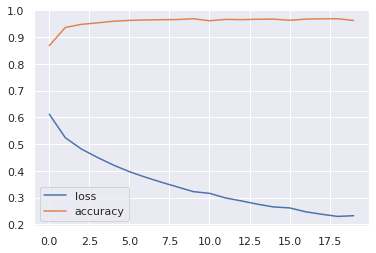

In [29]:
losses = pd.DataFrame(model.history.history)
losses.plot()

##Prediction & Evaluation

In [30]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [31]:
result = pd.DataFrame()
result['id'] = test['id']
result['target'] = pred
result.head()

,id,target
0,1,1
1,2,0
2,3,0
3,4,1
4,5,0


In [32]:
result.to_csv('submission_LSTM.csv',index=False)

#8. Bert Model

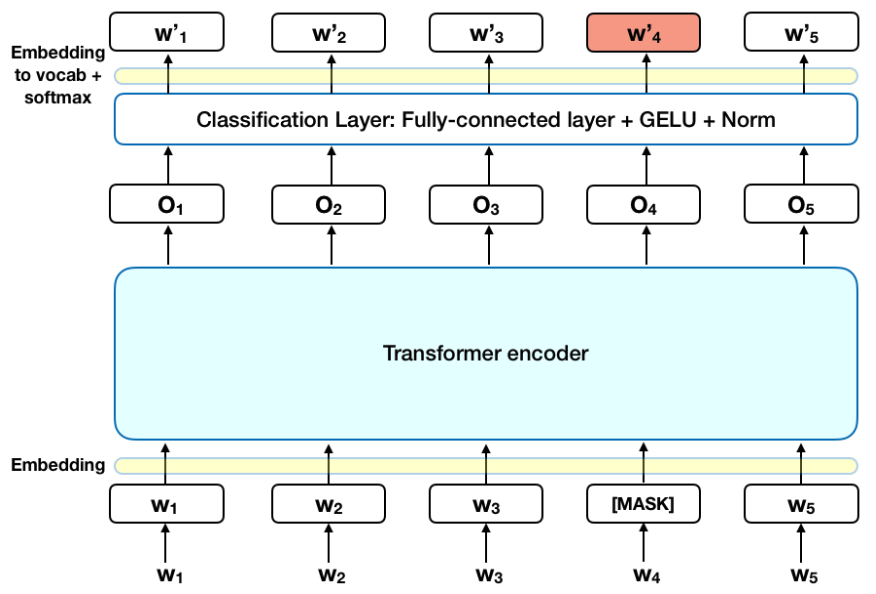

##Text Preprocessing for Bert

In [39]:
train_data = train.head(7000).copy()
val_data = train.tail(525).copy()

In [40]:
(X_train, y_train), (X_val, y_val), preproc = text.texts_from_df(train_df=train_data,
text_column = 'Tweet',label_columns = 'target',val_df = val_data,maxlen = 256,preprocess_mode = 'bert')

['not_target', 'target']
    not_target  target
3          0.0     1.0
6          1.0     0.0
11         1.0     0.0
17         1.0     0.0
20         0.0     1.0
['not_target', 'target']
       not_target  target
45248         0.0     1.0
45258         0.0     1.0
45263         0.0     1.0
45267         1.0     0.0
45269         1.0     0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


##Model Creation

In [41]:
model = text.text_classifier(name = 'bert',
                             train_data = (X_train, y_train),
                             preproc = preproc)

Is Multi-Label? False
maxlen is 256
done.


In [43]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train),
                   val_data = (X_val, y_val),
                   batch_size = 16)


##Model Training


In [44]:
learner.fit_onecycle(lr = 2e-5, epochs = 2)

predictor = ktrain.get_predictor(learner.model, preproc)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
314/314 [==============================] - 384s 1s/step - loss: 0.3732 - accuracy: 0.8115 - val_loss: 0.0470 - val_accuracy: 0.9905
Epoch 2/2
314/314 [==============================] - 358s 1s/step - loss: 0.0383 - accuracy: 0.9906 - val_loss: 0.0109 - val_accuracy: 0.9943


##Prediction & Evaluation

In [47]:
result = pd.DataFrame()
result['id'] = test['id']
result['target'] = predictor.predict(test['Tweet'].values)
result['target'] = result['target'].map(lambda x:1 if x=='target' else 0)
result.head()

,id,target
0,1,1
1,2,0
2,3,0
4,5,0
5,6,1


In [49]:
result.to_csv('submission_bert.csv',index=False)
